# Regression Models with cuML, scikit-learn, and XGBoost
This notebook demonstrates how to build and evaluate various regression models using cuML for GPU acceleration, scikit-learn for Partial Least Squares Regression, and XGBoost.

In [1]:
import copy
import numpy as np
import cuml
import cupy as cp
from cuml.linear_model import LinearRegression as cuLinearRegression
from cuml.linear_model import Lasso as cuLasso
from cuml.linear_model import Ridge as cuRidge
from cuml.linear_model import ElasticNet as cuElasticNet
from cuml.svm import SVR as cuSVR
from cuml.ensemble import RandomForestRegressor as cuRF
from cuml.neighbors import KNeighborsRegressor as cuKNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split as TTS
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LassoCV 
from sklearn.feature_selection import SelectFromModel
import os
os.chdir("/local-scratch/GlucoseProject/mobicom23_mobispectral/regression")
import sys
sys.path.append(os.getcwd())
from utils import *
from evaluate import *
from config import *

In [2]:
BANDS_WAVELENGTHS = [397.32, 400.20, 403.09, 405.97, 408.85, 411.74, 414.63, 417.52, 420.40, 423.29, 426.19, 429.08, 431.97, 434.87, 437.76, 440.66, 443.56, 446.45, 449.35, 452.25, 455.16, 458.06, 460.96, 463.87, 466.77, 469.68, 472.59, 475.50, 478.41, 481.32, 484.23, 487.14, 490.06, 492.97, 495.89, 498.80, 501.72, 504.64, 507.56, 510.48, 513.40, 516.33, 519.25, 522.18, 525.10, 528.03, 530.96, 533.89, 536.82, 539.75, 542.68, 545.62, 548.55, 551.49, 554.43, 557.36, 560.30, 563.24, 566.18, 569.12, 572.07, 575.01, 577.96, 580.90, 583.85, 586.80, 589.75, 592.70, 595.65, 598.60, 601.55, 604.51, 607.46, 610.42, 613.38, 616.34, 619.30, 622.26, 625.22, 628.18, 631.15, 634.11, 637.08, 640.04, 643.01, 645.98, 648.95, 651.92, 654.89, 657.87, 660.84, 663.81, 666.79, 669.77, 672.75, 675.73, 678.71, 681.69, 684.67, 687.65, 690.64, 693.62, 696.61, 699.60, 702.58, 705.57, 708.57, 711.56, 714.55, 717.54, 720.54, 723.53, 726.53, 729.53, 732.53, 735.53, 738.53, 741.53, 744.53, 747.54, 750.54, 753.55, 756.56, 759.56, 762.57, 765.58, 768.60, 771.61, 774.62, 777.64, 780.65, 783.67, 786.68, 789.70, 792.72, 795.74, 798.77, 801.79, 804.81, 807.84, 810.86, 813.89, 816.92, 819.95, 822.98, 826.01, 829.04, 832.07, 835.11, 838.14, 841.18, 844.22, 847.25, 850.29, 853.33, 856.37, 859.42, 862.46, 865.50, 868.55, 871.60, 874.64, 877.69, 880.74, 883.79, 886.84, 889.90, 892.95, 896.01, 899.06, 902.12, 905.18, 908.24, 911.30, 914.36, 917.42, 920.48, 923.55, 926.61, 929.68, 932.74, 935.81, 938.88, 941.95, 945.02, 948.10, 951.17, 954.24, 957.32, 960.40, 963.47, 966.55, 969.63, 972.71, 975.79, 978.88, 981.96, 985.05, 988.13, 991.22, 994.31, 997.40, 1000.49, 1003.58]


In [4]:
print(BANDS_WAVELENGTHS[182])

938.88


Deleted bands [182:186]

In [2]:
BANDS_WAVELENGTHS = [397.32, 400.20, 403.09, 405.97, 408.85, 411.74, 414.63, 417.52, 420.40, 423.29, 426.19, 429.08, 431.97, 434.87, 437.76, 440.66, 443.56, 446.45, 449.35, 452.25, 455.16, 458.06, 460.96, 463.87, 466.77, 469.68, 472.59, 475.50, 478.41, 481.32, 484.23, 487.14, 490.06, 492.97, 495.89, 498.80, 501.72, 504.64, 507.56, 510.48, 513.40, 516.33, 519.25, 522.18, 525.10, 528.03, 530.96, 533.89, 536.82, 539.75, 542.68, 545.62, 548.55, 551.49, 554.43, 557.36, 560.30, 563.24, 566.18, 569.12, 572.07, 575.01, 577.96, 580.90, 583.85, 586.80, 589.75, 592.70, 595.65, 598.60, 601.55, 604.51, 607.46, 610.42, 613.38, 616.34, 619.30, 622.26, 625.22, 628.18, 631.15, 634.11, 637.08, 640.04, 643.01, 645.98, 648.95, 651.92, 654.89, 657.87, 660.84, 663.81, 666.79, 669.77, 672.75, 675.73, 678.71, 681.69, 684.67, 687.65, 690.64, 693.62, 696.61, 699.60, 702.58, 705.57, 708.57, 711.56, 714.55, 717.54, 720.54, 723.53, 726.53, 729.53, 732.53, 735.53, 738.53, 741.53, 744.53, 747.54, 750.54, 753.55, 756.56, 759.56, 762.57, 765.58, 768.60, 771.61, 774.62, 777.64, 780.65, 783.67, 786.68, 789.70, 792.72, 795.74, 798.77, 801.79, 804.81, 807.84, 810.86, 813.89, 816.92, 819.95, 822.98, 826.01, 829.04, 832.07, 835.11, 838.14, 841.18, 844.22, 847.25, 850.29, 853.33, 856.37, 859.42, 862.46, 865.50, 868.55, 871.60, 874.64, 877.69, 880.74, 883.79, 886.84, 889.90, 892.95, 896.01, 899.06, 902.12, 905.18, 908.24, 911.30, 914.36, 917.42, 920.48, 923.55, 926.61, 929.68, 932.74, 935.81, 951.17, 954.24, 957.32, 960.40, 963.47, 966.55, 969.63, 972.71, 975.79, 978.88, 981.96, 985.05, 988.13, 991.22, 994.31, 997.40, 1000.49, 1003.58]

In [ ]:
data_root = '../datasets/dataset_skin/regression'
file_train = 'concatset_train.txt'
file_test = 'concatset_test.txt'
step = 1

In [17]:
data_root = '../datasets/dataset_glucose/Hyperspectral'
file_train = 'train_data.csv'
file_test = 'test_data.csv'
step = 1

In [ ]:
data_root = '../datasets/dataset_glucose/Hyperspectral'
file_train = 'train_data.csv'
file_test = 'region_test.csv'
step = 1

In [5]:
data_root = '../datasets/dataset_glucose/Hyperspectral'
file_train = 'train_data_temp.csv'
file_test = 'test_data_temp.csv'
step = 1

In [2]:
data_root = '../datasets/dataset_glucose/mobile/GooglePixel4XL'
file_train = 'mobi_train.csv'
file_test = 'mobi_test.csv'
step = 1

In [8]:
data_root = '../datasets/dataset_glucose/mobile/GooglePixel4XL'
file_train = 'mobi_train_temp.csv'
file_test = 'mobi_test_temp.csv'
step = 1

In [2]:
data_root = '../datasets/dataset_glucose/mobile/RaspberryPi-RGB+ToF'
file_train = 'mobi_train.csv'
file_test = 'mobi_test.csv'
step = 1

In [3]:
data_root = '../datasets/dataset_glucose/mobile/RaspberryPi-RGB+ToF'
file_train = 'mobi_train_temp.csv'
file_test = 'mobi_test_temp.csv'
step = 2

In [2]:
data_root = '../datasets/dataset_glucose/mobile/OnSemi-custom-RGB-NIR'
file_train = 'mobi_train.csv'
file_test = 'mobi_test.csv'
step = 1

In [2]:
data_root = '../datasets/dataset_glucose/mobile/RaspberryPi-RGB-NoIR'
file_train = 'mobi_train.csv'
file_test = 'mobi_test.csv'
step = 1

In [ ]:
patch_size = 64

# Be careful to the coordinate, it is opposite to intuitive and other library
xmin, ymin = 300, 120
xmax, ymax = xmin + patch_size, ymin + patch_size 

In [10]:
subject_id_test = [9]
# Everything else from the subject_id_test
subject_id_train = [9] 

In [4]:
model = XGBRegressor(device='cuda', tree_method='hist', random_state=42, n_estimators=250)

In [3]:
model = MLPRegressor(hidden_layer_sizes=(200, 200), random_state=42)

In [ ]:
cross_validate(model=model, data_root=data_root, labels_file='labels_hs.csv', temp_train_file=file_train, temp_test_file=file_test, step=step, dataset='hyper', show=True, save_path='../graph/MLP/ARD_CrossSubjects.png')


In [8]:
filter_rows_by_id("../" + HYPER_LABELS_FILE, "../" + TEST_FILE, subject_id_test)
# filter_rows_by_id("../" + HYPER_LABELS_FILE, "../" + TRAIN_FILE, subject_id_train)

In [6]:
filter_rows_by_id("../datasets/dataset_glucose/mobile/GooglePixel4XL/labels_GooglePixel.csv", "../datasets/dataset_glucose/mobile/GooglePixel4XL/mobi_test_temp.csv", subject_id_test)
# filter_rows_by_id("../" + HYPER_LABELS_FILE, "../" + TRAIN_FILE, subject_id_train)

In [11]:
filter_rows_by_id("../datasets/dataset_glucose/mobile/RaspberryPi-RGB+ToF/labels_ToF.csv", "../datasets/dataset_glucose/mobile/RaspberryPi-RGB+ToF/mobi_test_temp.csv", subject_id_test)
# filter_rows_by_id("../" + HYPER_LABELS_FILE, "../" + TRAIN_FILE, subject_id_train)

In [7]:
make_train_test_files("../" + HYPER_LABELS_FILE, '../datasets/dataset_glucose/Hyperspectral/train_data.csv', '../datasets/dataset_glucose/Hyperspectral/test_data.csv', 0.2)

In [ ]:
make_train_test_files("../", '../datasets/dataset_glucose/Hyperspectral/train_data_temp.csv', '../datasets/dataset_glucose/Hyperspectral/test_data_temp.csv', 0.2)

In [12]:
make_train_test_files("../datasets/dataset_glucose/mobile/RaspberryPi-RGB+ToF/mobi_test_temp.csv", "../datasets/dataset_glucose/mobile/RaspberryPi-RGB+ToF/mobi_train_temp.csv", "../datasets/dataset_glucose/mobile/RaspberryPi-RGB+ToF/mobi_test_temp.csv", 0.2)

In [7]:
make_train_test_files("../datasets/dataset_glucose/mobile/GooglePixel4XL/mobi_test_temp.csv", "../datasets/dataset_glucose/mobile/GooglePixel4XL/mobi_train_temp.csv", "../datasets/dataset_glucose/mobile/GooglePixel4XL/mobi_test_temp.csv", 0.2)

In [11]:
make_train_test_files('../datasets/dataset_glucose/mobile/OnSemi-custom-RGB-NIR/labels_OnSemi.csv', '../datasets/dataset_glucose/mobile/OnSemi-custom-RGB-NIR/mobi_train.csv', '../datasets/dataset_glucose/mobile/OnSemi-custom-RGB-NIR/mobi_test.csv', 0.2)

In [13]:
make_train_test_files('../datasets/dataset_glucose/mobile/RaspberryPi-RGB+ToF/labels_ToF.csv', '../datasets/dataset_glucose/mobile/RaspberryPi-RGB+ToF/mobi_train.csv', '../datasets/dataset_glucose/mobile/RaspberryPi-RGB+ToF/mobi_test.csv', 0.2)

In [15]:
make_train_test_files('../datasets/dataset_glucose/mobile/RaspberryPi-RGB-NoIR/labels_RaspberryPi-RGB-NoIR.csv', '../datasets/dataset_glucose/mobile/RaspberryPi-RGB-NoIR/mobi_train.csv', '../datasets/dataset_glucose/mobile/RaspberryPi-RGB-NoIR/mobi_test.csv', 0.2)

In [23]:
make_train_test_files('../datasets/dataset_glucose/mobile/GooglePixel4XL/labels_GooglePixel.csv', '../datasets/dataset_glucose/mobile/GooglePixel4XL/mobi_train.csv', '../datasets/dataset_glucose/mobile/GooglePixel4XL/mobi_test.csv', 0.2)

Loading Mobile dataset
Loading Mobile dataset


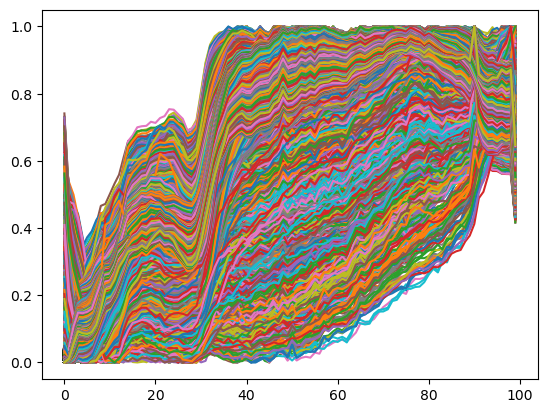

In [3]:
X, y, image_list_train, image_list_test = get_all_data('../datasets/dataset_glucose/mobile/RaspberryPi-RGB+ToF', 'mobi_train.csv', 'mobi_test.csv', 1, 'mobi')

In [ ]:
X, y, image_list_train, image_list_test = get_all_data(data_root, file_train, file_test, step, 'hyper')

In [3]:
X_train, y_train, X_test, y_test, test_data = prepare_data(data_root, file_train, file_test, step, 'mobi')
# X_train, X_val, y_train, y_val = TTS(X_train, y_train, test_size=0.3, random_state=42)

AttributeError: 'ImageList' object has no attribute 'image_list'

In [ ]:
print(test_data[0]['sig'].shape)

In [18]:
X_train, y_train, X_test, y_test, test_data = prepare_data(data_root, file_train, file_test, step, 'hyper')
# X_train, X_val, y_train, y_val = TTS(X_train, y_train, test_size=0.3, random_state=42)

Loading hyper dataset
Loading hyper dataset


In [ ]:
X, y, test_data = prepare_data2(data_root, file_name, step)
X_train, X_test, y_train, y_test = TTS(X, y, test_size=0.3, random_state=42)

In [4]:
# scaler = MinMaxScaler()
x_scaler = RobustScaler()
y_scaler = RobustScaler()
# x_scaler = StandardScaler()
# y_scaler = StandardScaler()
# scaler = StandardScaler()
X_train = x_scaler.fit_transform(X_train)
# X_val = scaler.transform(X_val)
X_test = x_scaler.transform(X_test)
y_train = y_scaler.fit_transform(y_train.reshape(-1, 1)).ravel()
y_test = y_scaler.transform(y_test.reshape(-1, 1)).ravel()

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(5897840, 50) (1485120, 50) (5897840,) (1485120,)


In [6]:
x_scaler = StandardScaler()
# y_scaler = StandardScaler()
X = x_scaler.fit_transform(X)
# y = y_scaler.fit_transform(y.reshape(-1, 1)).ravel()

In [8]:
# Concatenate image_list_train and image_list_test
test_data = image_list_train.get_list() + image_list_test.get_list()

In [ ]:
# Before robust scaling
for row in X_train:
    plt.plot(row)

In [ ]:
for row in X_train[::10, :]:
    # xtick should be from 55 to 66
    # plt.xticks(range(55, 66), np.arange(55, 66))
    plt.plot(row)

In [ ]:
for row in X_train_selected[::10, :]:
    plt.plot(row)

In [ ]:
# After robust scaling
for row in X_train:
    plt.plot(row)

In [ ]:
# After robust scaling
for row in X_test:
    plt.plot(row)

In [ ]:
# After robust scaling
for row in X_test:
    plt.plot(row)

In [4]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(675220, 196) (675220,) (172705, 196) (172705,)


In [13]:
# New data
# 910-960 nm: 911.30, 914.36, 917.42, 920.48, 923.55, 926.61, 929.68, 932.74, 935.81, 951.17, 954.24, 957.32, 960.40, 
# No 940, because of broken (182, 183, 184, 185)
# 840-860 nm: 838.14, 841.18, 844.22, 847.25, 850.29, 853.33, 856.37, 859.42, 862.46,
# 640-650 nm: 640.04, 643.01, 645.98, 648.95, 651.92,
# 480-490 nm: 478.41, 481.32, 484.23, 487.14, 490.06,
# 478.41, 481.32, 484.23, 487.14, 490.06, 492.97, 495.89, 640.04, 643.01, 645.98, 648.95, 651.92,
# 122-128, highest siganl 756.56, 759.56, 762.57, 765.58, 768.6, 771.61
# Get the corresponding index from bdands_wavelengths
indexes = [BANDS_WAVELENGTHS.index(w) for w in [ 478.41, 481.32, 484.23, 487.14, 490.06, 492.97, 495.89, 640.04, 643.01, 645.98, 648.95, 651.92, 756.56, 759.56, 762.57, 765.58, 768.6, 771.61, 838.14, 841.18, 844.22, 847.25, 850.29, 853.33, 856.37, 859.42, 862.46, 911.30, 914.36, 917.42, 920.48, 923.55, 926.61, 929.68, 932.74, 935.81, 951.17, 954.24, 957.32, 960.40, 963.47, 966.55, 969.63, 972.71, 975.79, 978.88, 981.96, 985.05, 988.13, 991.22]]
selected_features_indices = indexes


In [ ]:
indexes_test = [BANDS_WAVELENGTHS.index(w) for w in [ 478.41, 481.32, 484.23, 487.14, 490.06, 492.97, 495.89, 640.04, 643.01, 645.98, 648.95, 651.92, 838.14, 841.18, 844.22, 847.25, 850.29, 853.33, 856.37, 859.42, 862.46, 911.30, 914.36, 917.42, 920.48, 923.55, 926.61, 929.68, 932.74, 935.81, 951.17, 954.24, 957.32, 960.40, 963.47, 966.55, 969.63, 972.71, 975.79, 978.88, 981.96, 985.05, 988.13, 991.22]]
print(indexes_test)

In [23]:
# Based on SHAP top 30 XGBoost
selected_features_indices = [183, 184,   1,  96, 182,  97,  62, 122, 181, 177,  15, 103, 191, 140, 120,  16, 178,   2,
  95, 154,   0,  17, 161,  63,  54, 155, 200,  18,  68,  27]

In [30]:
# Based on SHAP top 50 XGBoost
selected_features_indices = [183, 184,   1,  96, 182,  97,  62, 122, 181, 177,  15, 103, 191, 140, 120,  16, 178,   2,
  95, 154,   0,  17, 161,  63,  54, 155, 200,  18,  68,  27, 179,  24, 203, 156,  42,  25,
  43, 130, 139, 159, 152, 157, 160, 158,  56,  40, 144,  19, 162, 189]

In [36]:
# Based on SHAP top 20 XGBoost old
selected_features_indices = [183, 184, 1,  96, 182,  97,  62, 122, 181, 177,  15, 103, 191, 140, 120,  16, 178,   2,
  95, 154]

In [19]:
# Based on SHAP top 20 XGBoost
selected_features_indices = [183, 184, 181, 182, 159,  22, 130,  27, 177,  34,  43,  25,  69,  42, 191,  54,  57,  37,  
   0, 162]

In [49]:
# print the selected wavelengths
indexes = [183, 184, 1,  96, 182,  97,  62, 122, 181, 177,  15, 103, 191, 140, 120,  16, 178,   2,
  95, 154]
for i in indexes:
    print(BANDS_WAVELENGTHS[i])

941.95
945.02
400.2
678.71
938.88
681.69
577.96
756.56
935.81
923.55
440.66
699.6
966.55
810.86
750.54
443.56
926.61
403.09
675.73
853.33


In [44]:
# Based on SHAP top 20 MLP
indexes = [BANDS_WAVELENGTHS.index(w) for w in [941.95, 945.02, 522.18, 938.88, 519.25, 678.71, 675.73, 865.5, 669.77, 525.1, 528.03, 672.75, 513.4, 868.55,  657.87, 935.81, 507.56, 859.42, 871.6, 516.33]]
selected_features_indices = indexes

In [ ]:
# Drop X_train index 182, 183, 184, 185
selected_features_indices = np.delete(np.array(range(204)), [182, 183, 184, 185])

In [ ]:
# For mobi dataset
# Drop bands index 61 (183) in 68 bands of mobi dataset
delete_bands = [60]
selected_features_indices = np.delete(np.array(range(67)), delete_bands)

In [ ]:
# From XGBoost feature importance
# Get the corresponding index from bdands_wavelengths
indexes = [BANDS_WAVELENGTHS.index(w) for w in [871.6, 874.64, 657.87, 446.45, 859.42, 625.22, 862.46, 972.71, 759.56, 449.35, 929.68, 865.5, 634.11, 687.65, 586.8, 917.42, 478.41, 577.96, 868.55, 466.77, 856.37, 969.63, 699.6, 960.4, 935.81, 504.64, 985.05, 853.33, 684.67, 583.85, 911.3, 580.9, 923.55, 771.61, 975.79, 484.23, 804.81, 978.88, 575.01, 660.84, 475.5, 945.02, 798.77, 601.55, 472.59, 607.46, 628.18, 616.34, 850.29, 693.62]]
selected_features_indices = indexes


In [ ]:
# New data
# From XGBoost feature importance
# Get the corresponding index from bdands_wavelengths
indexes = [BANDS_WAVELENGTHS.index(w) for w in [957.32, 628.18, 963.47, 966.55, 645.98, 960.4, 498.8, 443.56, 643.01, 501.72, 554.43, 440.66, 938.88, 678.71, 948.1, 577.96, 405.97, 507.56, 560.3, 504.64, 681.69, 859.42, 575.01, 886.84, 935.81, 446.45, 672.75, 856.37, 865.5, 660.84, 813.89, 929.68, 610.42, 981.96, 841.18, 449.35, 510.48, 868.55, 926.61, 492.97, 607.46, 622.26, 853.33, 969.63, 914.36, 847.25, 1003.58, 684.67, 804.81, 545.62]]
selected_features_indices = indexes

In [5]:
# Using wavelength BANDS_WAVELENGTHS that greater than 700 nm
# indexes = [BANDS_WAVELENGTHS.index(w) for w in [957.32, 628.18, 963.47, 966.55, 645.98, 960.4, 498.8, 443.56, 643.01, 501.72, 554.43, 440.66, 938.88, 678.71, 948.1, 577.96, 405.97, 507.56, 560.3, 504.64, 681.69, 859.42, 575.01, 886.84, 935.81, 446.45, 672.75, 856.37, 865.5, 660.84, 813.89, 929.68, 610.42, 981.96, 841.18, 449.35, 510.48, 868.55, 926.61, 492.97, 607.46, 622.26, 853.33, 969.63, 914.36, 847.25, 1003.58, 684.67, 804.81, 545.62]]
indexes = [BANDS_WAVELENGTHS.index(w) for w in BANDS_WAVELENGTHS if w > 600]
print(len(indexes))
# Select only half of the bands in the indexes
selected_features_indices = indexes[::2]
print(len(selected_features_indices))

130
65


In [ ]:
# for image in test_data:
#     print(image['sig'].shape)

In [ ]:
for image in test_data:
    image['sig'] = x_scaler.transform(image['sig'])
    image['label'] = y_scaler.transform(image['label'].reshape(-1, 1)).ravel()
    

In [21]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1477970, 204) (1477970,) (371280, 204) (371280,)


In [20]:
X_train_selected = X_train[:, selected_features_indices]
# X_val_selected = X_val[:, selected_features_indices]
X_test_selected = X_test[:, selected_features_indices]

In [22]:
# X_train_selected = X_train[:, selected_features_indices]
# # X_val_selected = X_val[:, selected_features_indices]
# X_test_selected = X_test[:, selected_features_indices]

# scaler = MinMaxScaler()
x_scaler = RobustScaler()
y_scaler = RobustScaler()
# scaler = StandardScaler()
X_train_selected = x_scaler.fit_transform(X_train_selected)
# X_val = scaler.transform(X_val)
X_test_selected = x_scaler.transform(X_test_selected)
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1)).ravel()
y_test_scaled = y_scaler.transform(y_test.reshape(-1, 1)).ravel()


test_data_selected = copy.deepcopy(test_data)

for image in test_data_selected:
    image['sig'] = image['sig'][:, selected_features_indices]

In [39]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1477970, 204) (1477970,) (371280, 204) (371280,)


In [23]:
# Print the shape of X_train_selected, X_test_selected
print(X_train_selected.shape, X_test_selected.shape)

(1477970, 20) (371280, 20)


## PCR (PCA + Linear Regression)

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
pcr = make_pipeline(StandardScaler(), PCA(n_components=25), LinearRegression())
pcr.fit(X_train, y_train)
y_pred_pcr = cp.asnumpy(pcr.predict(X_test))
mse_pcr = mean_squared_error(y_test, y_pred_pcr)
print(f"ARD by signatures: {ARD(y_pred_pcr, y_test).mean()}" )
evaluate_image_CEG(test_data, model=pcr)
ard = ard_image(test_data, pcr)
print("ARD by images: ", ard)
print("Average ARD: ", ard.mean())

In [ ]:
X_train = cp.array(X_train)
# X_val = cp.array(X_val)
X_test = cp.array(X_test)

In [ ]:
X_train_selected = cp.array(X_train_selected)
# X_val_selected = cp.array(X_val_selected)
X_test_selected = cp.array(X_test_selected)

In [ ]:
# Linear Regression
# 49 bands, F score
lin_reg = cuLinearRegression()
lin_reg.fit(X_train_selected, y_train)
y_pred_lin = cp.asnumpy(lin_reg.predict(X_test_selected))
mse_lin = mean_squared_error(y_test, y_pred_lin)
print(f"ARD by signatures: {ARD(y_pred_lin, y_test).mean()}" )
evaluate_image_CEG(test_data_selected, model=lin_reg)
ard = ard_image(test_data_selected, lin_reg)
print("ARD by images: ", ard)
print("Average ARD: ", ard.mean())

In [ ]:
# Linear Regression
# 50 bands, XGBoost
lin_reg = cuLinearRegression()
lin_reg.fit(X_train_selected, y_train)
y_pred_lin = cp.asnumpy(lin_reg.predict(X_test_selected))
mse_lin = mean_squared_error(y_test, y_pred_lin)
print(f"ARD by signatures: {ARD(y_pred_lin, y_test).mean()}" )
evaluate_image_CEG(test_data_selected, model=lin_reg)
ard = ard_image(test_data_selected, lin_reg)
print("ARD by images: ", ard)
print("Average ARD: ", ard.mean())

In [ ]:
# Lasso Regression
# 50 bands, F score
lasso_reg = cuLasso()
lasso_reg.fit(X_train_selected, y_train)
y_pred_lasso = cp.asnumpy(lasso_reg.predict(X_test_selected))
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
print(f"ARD by signatures: {ARD(y_pred_lasso, y_test).mean()}" )
evaluate_image_CEG(test_data_selected, model=lasso_reg)
ard = ard_image(test_data_selected, lasso_reg)
print("ARD by images: ", ard)
print("Average ARD: ", ard.mean())

In [ ]:
# Lasso Regression
# 50 bands, XGBoost
lasso_reg = cuLasso()
lasso_reg.fit(X_train_selected, y_train)
y_pred_lasso = cp.asnumpy(lasso_reg.predict(X_test_selected))
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
print(f"ARD by signatures: {ARD(y_pred_lasso, y_test).mean()}" )
evaluate_image_CEG(test_data_selected, model=lasso_reg)
ard = ard_image(test_data_selected, lasso_reg)
print("ARD by images: ", ard)
print("Average ARD: ", ard.mean())

In [ ]:
# Ridge Regression
ridge_reg = cuRidge()
ridge_reg.fit(X_train_selected, y_train)
y_pred_ridge = cp.asnumpy(ridge_reg.predict(X_test_selected))
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
print(f"ARD by signatures: {ARD(y_pred_ridge, y_test).mean()}" )
evaluate_image_CEG(test_data_selected, model=ridge_reg)
ard = ard_image(test_data_selected, ridge_reg)
print("ARD by images: ", ard)
print("Average ARD: ", ard.mean())

In [ ]:
# Elastic Net
elastic_net = cuElasticNet()
elastic_net.fit(X_train_selected, y_train)
y_pred_elastic = cp.asnumpy(elastic_net.predict(X_test_selected))
mse_elastic = mean_squared_error(y_test, y_pred_elastic)
print(f"ARD by signatures: {ARD(y_pred_elastic, y_test).mean()}" )
evaluate_image_CEG(test_data_selected, model=elastic_net)
ard = ard_image(test_data_selected, elastic_net)
print("ARD by images: ", ard)
print("Average ARD: ", ard.mean())

In [ ]:
mlp_reg = load_model('./Models/MLP100Bands_NoScaler.pkl')
y_pred_mlp = cp.asnumpy(mlp_reg.predict(X))
mse_mlp = mean_squared_error(y, y_pred_mlp)
# print(f"ARD by signatures: {ARD(y_pred_mlp, y_test).mean()}" )
ard = ard_image(test_data, mlp_reg)
print("ARD by images: ", ard)
print("Average ARD: ", ard.mean())
evaluate_image_CEG(test_data, model=mlp_reg)
evaluate_image_SEG(test_data, model=mlp_reg)
CDF(ard)

ARD by images:  [2.75098473e-01 3.01664144e-01 2.74578840e-01 2.77982742e-01
 3.82529229e-01 2.65944928e-01 3.86803359e-01 2.89470077e-01
 1.94535881e-01 1.38589516e-01 2.87903905e-01 2.36733124e-01
 2.19122171e-01 3.10425431e-01 2.22365677e-01 2.98981905e-01
 2.64512479e-01 2.35841051e-01 2.53563613e-01 2.66955137e-01
 2.92481750e-01 2.21229687e-01 1.32317647e-01 1.95893764e-01
 2.07956098e-02 5.64524680e-02 2.30372790e-02 2.13130891e-01
 1.11591794e-01 6.99441880e-02 3.49614829e-01 1.32094786e-01
 5.34325302e-01 9.22198147e-02 1.23354733e-01 2.15001926e-01
 1.36460572e-01 2.23790482e-01 6.44292384e-02 1.08208120e-01
 4.61765081e-02 2.17676789e-01 1.22494735e-01 2.61398181e-02
 2.03352571e-01 5.18313423e-02 1.21259794e-01 1.08746529e-01
 3.33660585e-03 3.14180970e-01 1.69448540e-01 7.20582232e-02
 2.83251882e-01 2.09237739e-01 2.77234167e-01 2.01651677e-01
 9.97936130e-02 2.51741737e-01 1.50561452e-01 6.45873696e-02
 1.57597587e-01 1.33550614e-01 2.40910321e-01 1.41027182e-01
 2.00228

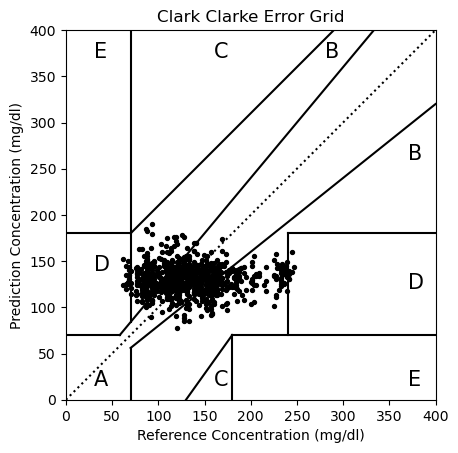

<Figure size 640x480 with 0 Axes>

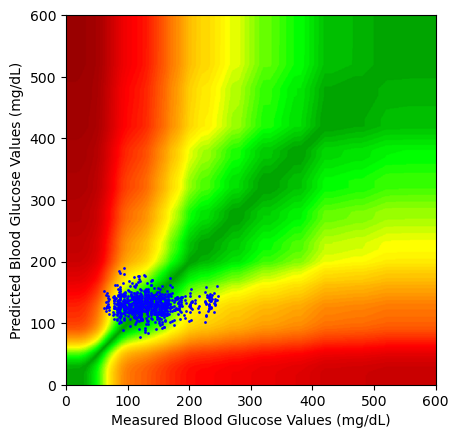

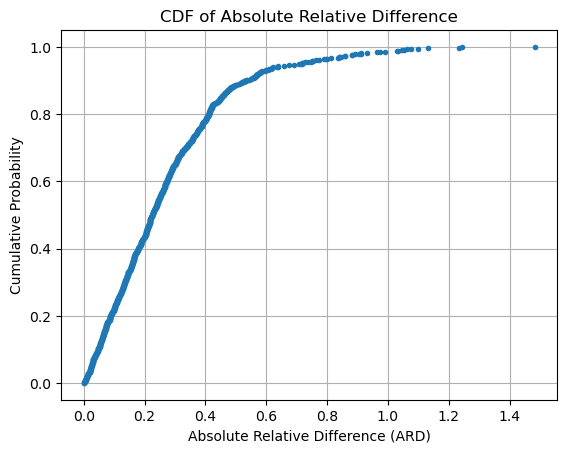

<Figure size 640x480 with 0 Axes>

In [9]:
mlp_reg = load_model('./Models/MLP100bands.pkl')
y_pred_mlp = cp.asnumpy(mlp_reg.predict(X))
mse_mlp = mean_squared_error(y, y_pred_mlp)
# print(f"ARD by signatures: {ARD(y_pred_mlp, y_test).mean()}" )
ard = ard_image(test_data, mlp_reg, scaler_X=x_scaler, scaler_y=y_scaler)
print("ARD by images: ", ard)
print("Average ARD: ", ard.mean())
evaluate_image_CEG(test_data, model=mlp_reg, scaler_X=x_scaler, scaler_y=y_scaler)
evaluate_image_SEG(test_data, model=mlp_reg, scaler_X=x_scaler, scaler_y=y_scaler)
CDF(ard)

In [ ]:
save_model(mlp_reg, './Models/MLP100Bands_NoScaler.pkl')

In [7]:
print(X_train.shape)

(717470, 200)


ARD by images:  [7.00212181e-01 5.87435842e-01 7.30468273e-01 8.37697566e-01
 2.47844234e-01 1.67957544e-01 1.32564396e-01 4.51138079e-01
 3.03903818e-01 3.66100729e-01 2.25718498e-01 1.20339192e-01
 9.99484807e-02 1.63972765e-01 6.38509393e-02 1.13075383e-01
 1.87163994e-01 1.80926129e-01 1.63235053e-01 8.26206580e-02
 2.40480900e-02 3.20029212e-03 1.91241533e-01 6.79831579e-02
 2.21139207e-01 9.64528918e-02 4.37482744e-02 1.42569924e-02
 2.15233579e-01 1.27153039e-01 2.63863742e-01 2.53893167e-01
 1.67023778e-01 3.23296249e-01 3.40252519e-01 1.44431901e+00
 2.26803515e-02 8.93415734e-02 1.54155806e-01 4.07716572e-01
 1.14117786e-02 2.33818725e-01 5.05845249e-01 1.77603155e-01
 5.26846886e-01 1.26218945e-01 2.27790102e-01 1.01041965e-01
 1.10390618e-01 1.14103712e-01 1.74710929e-01 9.79738235e-02
 1.79135889e-01 1.24573678e-01 1.67061865e-01 1.45312831e-01
 1.18145740e+00 9.48711812e-01 6.03336692e-02 5.10726213e-01
 5.03626764e-02 2.07603619e-01 1.96710557e-01 4.96627875e-02
 7.55539

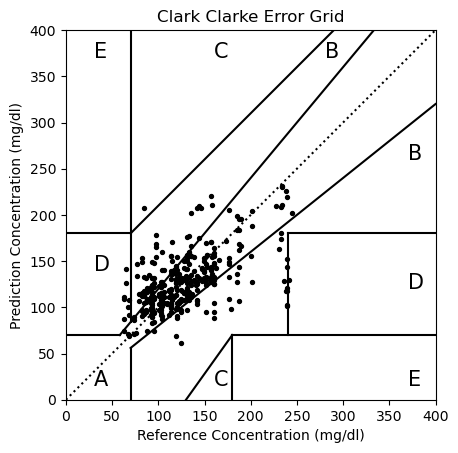

<Figure size 640x480 with 0 Axes>

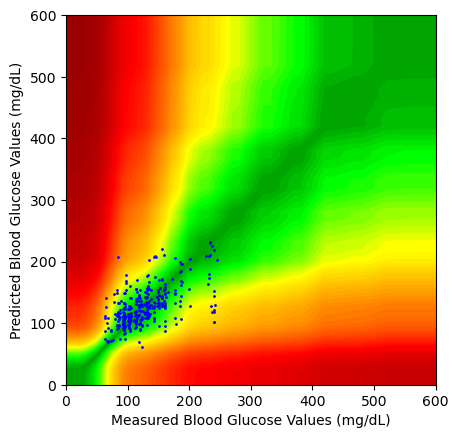

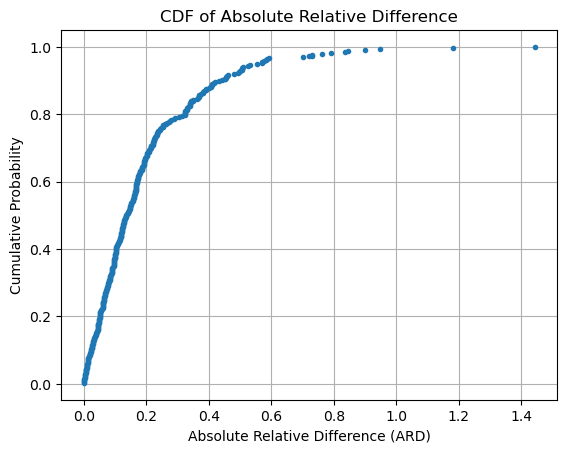

<Figure size 640x480 with 0 Axes>

In [7]:
# Multi-Layer Perceptron
mlp_reg = MLPRegressor((200, 100, 16), random_state=42)
mlp_reg.fit(cp.asnumpy(X_train), cp.asnumpy(y_train))
y_pred_mlp = cp.asnumpy(mlp_reg.predict(X_test))
mse_mlp = mean_squared_error(y_test, y_pred_mlp)
# print(f"ARD by signatures: {ARD(y_pred_mlp, y_test).mean()}" )
ard = ard_image(test_data, mlp_reg, scaler_X=x_scaler, scaler_y=y_scaler)
print("ARD by images: ", ard)
print("Average ARD: ", ard.mean())
evaluate_image_CEG(test_data, model=mlp_reg, scaler_X=x_scaler, scaler_y=y_scaler)
evaluate_image_SEG(test_data, model=mlp_reg, scaler_X=x_scaler, scaler_y=y_scaler)
CDF(ard)
save_model(mlp_reg, './Models/MLP_sklearn_GooglePixel.pkl')

In [ ]:
import scipy.stats.pearsonr as pearsonr
print(pearsonr(predictions, labels))

ARD by images:  [1.43094838e-01 1.25179455e-01 1.37938097e-01 2.98647601e-02
 1.72286958e-01 3.01180910e-02 2.85122786e-02 2.42010877e-01
 3.32549423e-01 4.08174051e-03 1.17435299e-01 2.41978001e-02
 1.54570058e-01 3.64755243e-02 1.14297010e-01 4.27090563e-02
 1.87139714e-03 1.47652626e-01 1.39999509e-01 9.09748673e-02
 1.94626004e-02 8.50214739e-04 5.06589152e-02 3.98589969e-01
 1.19225398e-01 1.85755696e-02 2.10507959e-01 1.73969269e-01
 1.87734947e-01 2.14075446e-02 7.54259750e-02 3.75948250e-01
 5.12701645e-02 9.47185084e-02 9.62993056e-02 8.73240903e-02
 5.34070395e-02 2.64132023e-01 1.05162874e-01 8.64169560e-03
 3.83249447e-02 7.66558647e-02 4.89760861e-02 3.81895959e-01
 1.49878398e-01 2.41292659e-02 5.05428195e-01 8.38095024e-02
 3.92560586e-02 4.02475661e-03 3.99597585e-02 3.28113846e-02
 1.48523971e-01 2.43922248e-02 2.36918200e-02 5.20221442e-02
 2.38737045e-03 4.06977459e-04 8.64467397e-02 1.08064078e-01
 1.04473587e-02 1.40339196e-01 1.04070745e-01 8.03128928e-02
 9.04240

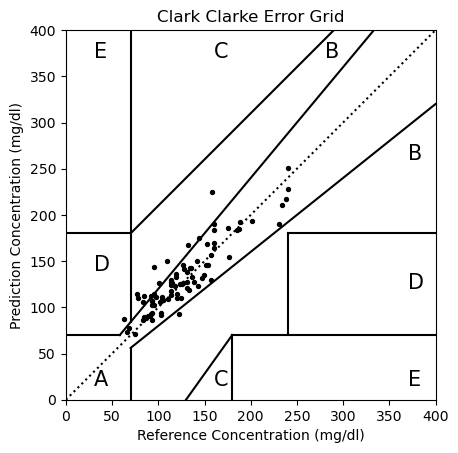

<Figure size 640x480 with 0 Axes>

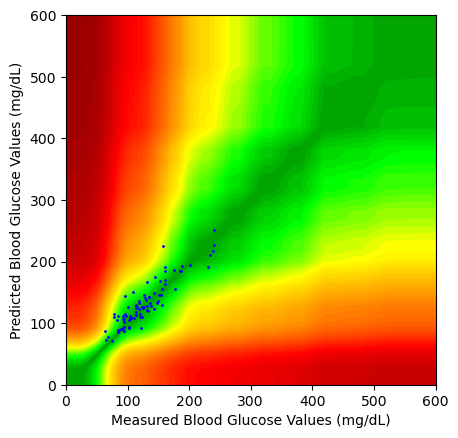

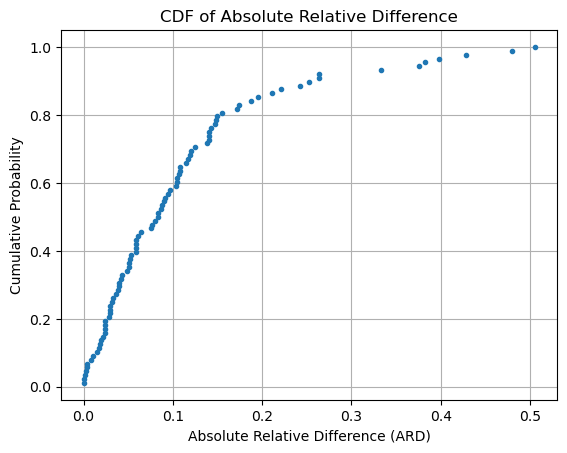

Pearson correlation coefficient: 0.9044330990287248
P-value: 1.4424779650030983e-33


<Figure size 640x480 with 0 Axes>

In [25]:
# Multi-Layer Perceptron
mlp_reg = MLPRegressor((200, 100, 16), random_state=42)
mlp_reg.fit(cp.asnumpy(X_train_selected), cp.asnumpy(y_train_scaled))
y_pred_mlp = cp.asnumpy(mlp_reg.predict(X_test_selected))
mse_mlp = mean_squared_error(y_test_scaled, y_pred_mlp)
ard = ard_image(test_data_selected, mlp_reg, scaler_X=x_scaler, scaler_y=y_scaler)
# print(f"ARD by signatures: {ARD(y_pred_mlp, y_test).mean()}" )
print("ARD by images: ", ard)
print("Average ARD: ", ard.mean())
evaluate_image_CEG(test_data_selected, model=mlp_reg, scaler_X=x_scaler, scaler_y=y_scaler)
evaluate_image_SEG(test_data_selected, model=mlp_reg, scaler_X=x_scaler, scaler_y=y_scaler)
CDF(ard)
evaluate_image_PCC(test_data_selected, model=mlp_reg, scaler_X=x_scaler, scaler_y=y_scaler)
save_model(mlp_reg, './Models/MLP_sklearn_selected20_SHAP.pkl')

ARD by images:  [5.57700574e-01 5.81970632e-01 6.92594409e-01 5.93975127e-01
 3.45470399e-01 2.31208831e-01 1.33076310e-01 3.15334141e-01
 2.61402339e-01 4.23010260e-01 1.97923943e-01 8.73831213e-02
 6.13491498e-02 8.26889053e-02 1.78626850e-02 2.19952241e-02
 1.36262745e-01 1.38829306e-01 7.42563680e-02 7.93268830e-02
 7.43364124e-03 5.44876466e-03 7.99352452e-02 2.80494183e-01
 1.71932187e-02 2.26489007e-02 2.23022729e-01 3.86422276e-02
 2.98418969e-01 8.90094191e-02 2.96367377e-01 3.17632407e-01
 1.22242399e-01 5.45361817e-01 4.58551228e-01 1.16823983e+00
 7.93105960e-02 2.94802641e-03 2.38436162e-01 3.52865338e-01
 3.31134349e-02 1.11623362e-01 8.54520723e-02 9.43361521e-02
 2.38130018e-01 1.96874723e-01 3.64365816e-01 5.84318787e-02
 1.09060191e-01 1.20076783e-01 1.20774060e-01 3.86245474e-02
 5.45404404e-02 1.04853764e-01 2.07606629e-01 2.04983398e-01
 1.45404375e+00 8.00142169e-01 1.82898417e-01 5.43294966e-01
 4.74398136e-02 9.60795879e-02 1.31140202e-01 1.14251710e-01
 5.51695

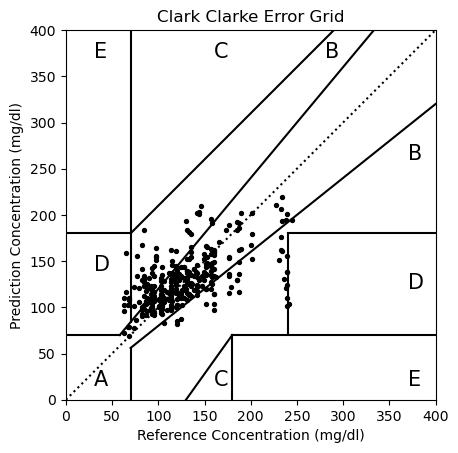

<Figure size 640x480 with 0 Axes>

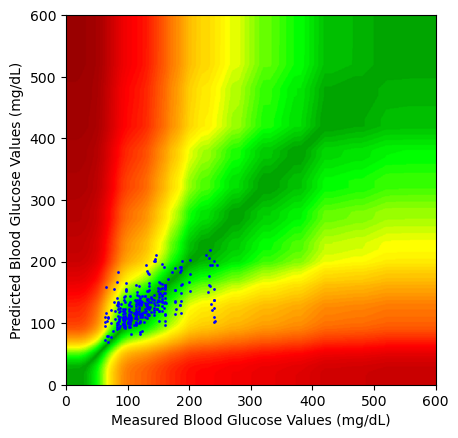

In [9]:
# KNN
knn_reg = cuKNeighborsRegressor()
knn_reg.fit(X_train, y_train)
y_pred_knn = cp.asnumpy(knn_reg.predict(X_test))
mse_knn = mean_squared_error(y_test, y_pred_knn)
# print(f"ARD by signatures: {ARD(y_pred_knn, y_test).mean()}" )
ard = ard_image(test_data, knn_reg, scaler_X=x_scaler, scaler_y=y_scaler)
print("ARD by images: ", ard)
print("Average ARD: ", ard.mean())
evaluate_image_CEG(test_data, model=knn_reg, scaler_X=x_scaler, scaler_y=y_scaler)
evaluate_image_SEG(test_data, model=knn_reg, scaler_X=x_scaler, scaler_y=y_scaler)
evaluate_image_PCC(test_data, model=knn_reg, scaler_X=x_scaler, scaler_y=y_scaler)
CDF(ard)

In [ ]:
# KNN
# 50 bands, F score
knn_reg = cuKNeighborsRegressor()
knn_reg.fit(X_train_selected, y_train_scaled)
y_pred_knn = cp.asnumpy(knn_reg.predict(X_test_selected))
mse_knn = mean_squared_error(y_test_scaled, y_pred_knn)
# print(f"ARD by signatures: {ARD(y_pred_knn, y_test).mean()}" )
ard = ard_image(test_data_selected, knn_reg, scaler_X=x_scaler, scaler_y=y_scaler)
print("ARD by images: ", ard)
print("Average ARD: ", ard.mean())
evaluate_image_CEG(test_data_selected, model=knn_reg, scaler_X=x_scaler, scaler_y=y_scaler)
evaluate_image_SEG(test_data_selected, model=knn_reg, scaler_X=x_scaler, scaler_y=y_scaler)

In [ ]:
print(X_train_selected.shape, y_train_scaled.shape, X_test_selected.shape, y_test_scaled.shape)

In [ ]:
# KNN
# 50 bands, XGBoost
knn_reg = cuKNeighborsRegressor()
knn_reg.fit(X_train_selected, y_train)
y_pred_knn = cp.asnumpy(knn_reg.predict(X_test_selected))
mse_knn = mean_squared_error(y_test, y_pred_knn)
print(f"ARD by signatures: {ARD(y_pred_knn, y_test).mean()}" )
evaluate_image_CEG(test_data_selected, model=knn_reg)
ard = ard_image(test_data_selected, knn_reg)
print("ARD by images: ", ard)
print("Average ARD: ", ard.mean())

In [ ]:
# Random Forest
rf_reg = cuRF(n_estimators=250, random_state=42)
rf_reg.fit(X_train, y_train)
y_pred_rf = cp.asnumpy(rf_reg.predict(X_test))
mse_rf = mean_squared_error(y_test, y_pred_rf)
# print(f"ARD by signatures: {ARD(y_pred_rf, y_test).mean()}" )
ard = ard_image(test_data, rf_reg, scaler_X=x_scaler, scaler_y=y_scaler)
print("ARD by images: ", ard)
print("Average ARD: ", ard.mean())
evaluate_image_CEG(test_data, model=rf_reg, scaler_X=x_scaler, scaler_y=y_scaler)
evaluate_image_SEG(test_data, model=rf_reg, scaler_X=x_scaler, scaler_y=y_scaler)
CDF(ard)
# save_model(mlp_reg, './Models/RF.pkl')

In [ ]:
print(y_pred_rf)

In [ ]:
# Random Forest Selected
rf_reg = cuRF(n_estimators=150, random_state=42)
rf_reg.fit(X_train_selected, y_train_scaled)
y_pred_rf = cp.asnumpy(rf_reg.predict(X_test_selected))
mse_rf = mean_squared_error(y_test_scaled, y_pred_rf)
# print(f"ARD by signatures: {ARD(y_pred_rf, y_test).mean()}" )
ard = ard_image(test_data_selected, rf_reg, scaler_X=x_scaler, scaler_y=y_scaler)
print("ARD by images: ", ard)
print("Average ARD: ", ard.mean())
evaluate_image_CEG(test_data_selected, model=rf_reg, scaler_X=x_scaler, scaler_y=y_scaler)
evaluate_image_SEG(test_data_selected, model=rf_reg, scaler_X=x_scaler, scaler_y=y_scaler)
CDF(ard)

In [ ]:
# Random Forest Selected
# 50 bands, XGBoost
rf_reg = cuRF()
rf_reg.fit(X_train_selected, y_train)
y_pred_rf = cp.asnumpy(rf_reg.predict(X_test_selected))
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f"ARD by signatures: {ARD(y_pred_rf, y_test).mean()}" )
evaluate_image_CEG(test_data_selected, model=rf_reg)
ard = ard_image(test_data_selected, rf_reg)
print("ARD by images: ", ard)
print("Average ARD: ", ard.mean())

0.50219816
ARD by images:  [3.29615742e-01 4.86841440e-01 5.95061600e-01 5.07823825e-01
 2.90903568e-01 2.70099133e-01 2.39446640e-01 2.43799940e-01
 1.31937638e-01 3.14631194e-01 1.91833183e-01 1.87377378e-01
 3.47978100e-02 3.35610565e-03 9.33882222e-03 1.79504491e-02
 1.30542099e-01 1.32781982e-01 9.87044722e-02 1.34672701e-01
 6.47456348e-02 2.55332515e-02 2.68439442e-01 1.14059612e-01
 8.26027244e-02 6.95371404e-02 7.83332288e-02 4.05401224e-03
 2.21562713e-01 9.26558115e-03 1.40855685e-01 1.21065654e-01
 3.65801632e-01 4.39657807e-01 4.27823573e-01 1.11083472e+00
 1.42907351e-01 1.46451384e-01 2.08424225e-01 2.75011122e-01
 3.51542942e-02 8.66411626e-02 1.33294731e-01 3.36606242e-02
 3.31353486e-01 2.52406836e-01 3.46061766e-01 1.89014852e-01
 1.05853602e-01 3.39366719e-02 8.14053579e-04 1.20606367e-02
 9.97594297e-02 1.10456713e-01 1.61190599e-01 1.43487558e-01
 1.33617604e+00 8.08093905e-01 5.92582822e-01 7.80404389e-01
 9.98800434e-03 7.28659034e-02 1.04652815e-01 1.48071811e-

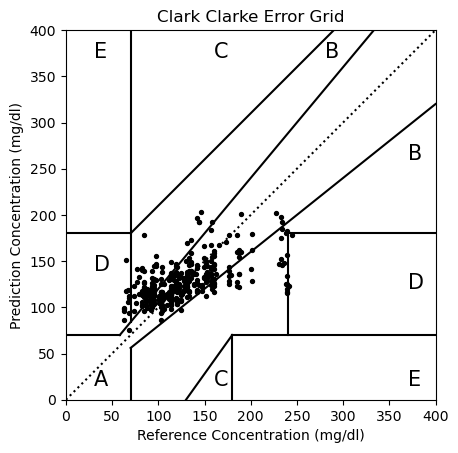

<Figure size 640x480 with 0 Axes>

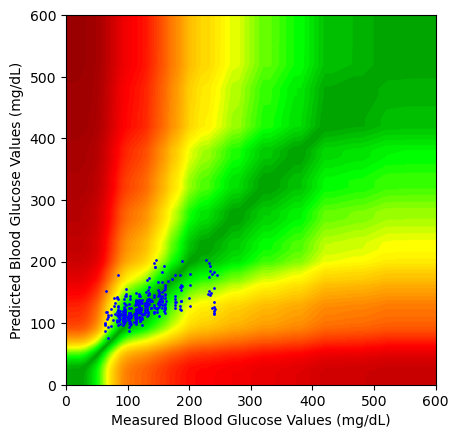

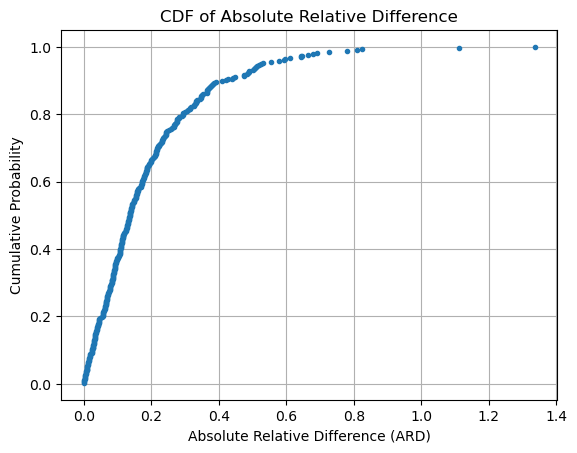

<Figure size 640x480 with 0 Axes>

In [5]:
# XGBoost
xgb_reg = XGBRegressor(device='cuda', tree_method='hist', random_state=42, n_estimators=250)
xgb_reg.fit(X_train, y_train)
y_pred_xgb = cp.asnumpy(xgb_reg.predict(X_test))
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
print(mse_xgb)
# print(f"ARD by signatures: {ARD(y_pred_xgb, y_test).mean()}" )
ard = ard_image(test_data, xgb_reg, scaler_X=x_scaler, scaler_y=y_scaler)
print("ARD by images: ", ard)
print("Average ARD: ", ard.mean())
evaluate_image_CEG(test_data, model=xgb_reg, scaler_X=x_scaler, scaler_y=y_scaler)
evaluate_image_SEG(test_data, model=xgb_reg, scaler_X=x_scaler, scaler_y=y_scaler)
CDF(ard)
# save_model(xgb_reg, './Models/XGBoost100.pkl')

0.5236276
ARD by images:  [5.61783969e-01 5.24454474e-01 6.44605696e-01 5.92913687e-01
 3.35080594e-01 2.28609234e-01 2.03685194e-01 2.86944538e-01
 2.52710551e-01 3.20814192e-01 1.99765518e-01 1.36940092e-01
 5.90929128e-02 1.34449247e-02 1.26973139e-02 9.72672540e-04
 1.55816615e-01 1.44730419e-01 7.02721626e-02 1.13507874e-01
 7.19036758e-02 1.50579605e-02 2.19779342e-01 8.38333741e-02
 2.65528751e-03 2.22335830e-02 1.49927720e-01 2.71051154e-02
 2.84775823e-01 4.92371619e-02 1.66724369e-01 1.65264547e-01
 2.81916291e-01 5.05988300e-01 4.25514430e-01 1.15266442e+00
 6.24579936e-03 6.58363998e-02 1.96131110e-01 3.35660607e-01
 3.24326716e-02 1.33514538e-01 2.49560505e-01 7.52381980e-02
 3.16821128e-01 1.87400356e-01 3.45131993e-01 1.12769224e-01
 7.19705895e-02 5.06464168e-02 4.16076221e-02 4.23693135e-02
 9.54670906e-02 1.02641761e-01 2.12484255e-01 1.81306913e-01
 1.41412210e+00 8.05283248e-01 3.67384702e-01 6.33576393e-01
 1.44668370e-02 3.73440906e-02 1.53187469e-01 1.39625683e-0

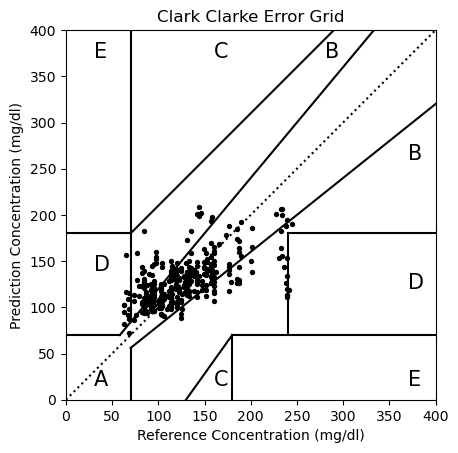

<Figure size 640x480 with 0 Axes>

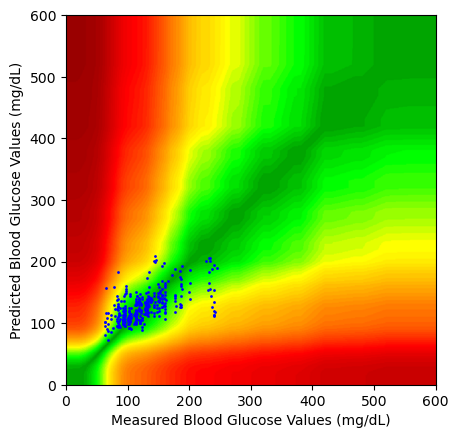

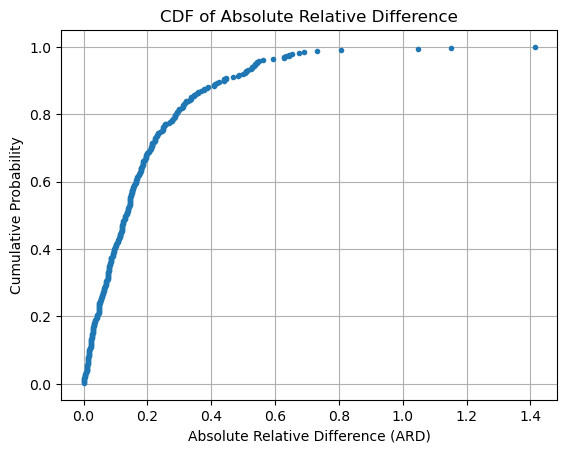

<Figure size 640x480 with 0 Axes>

In [6]:
# XGBoost
xgb_reg = XGBRegressor(n_estimators=800
                    ,subsample=0.894736842105263
                    ,random_state=42
                    ,tree_method='hist'
                    ,device='cuda'
                    ,n_job=-1
                    ,learning_rate=0.26
                    ,gamma=0.006
                    ,max_depth=8)

xgb_reg.fit(X_train, y_train)
y_pred_xgb = cp.asnumpy(xgb_reg.predict(X_test))
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
print(mse_xgb)
# print(f"ARD by signatures: {ARD(y_pred_xgb, y_test).mean()}" )
ard = ard_image(test_data, xgb_reg, scaler_X=x_scaler, scaler_y=y_scaler)
print("ARD by images: ", ard)
print("Average ARD: ", ard.mean())
evaluate_image_CEG(test_data, model=xgb_reg, scaler_X=x_scaler, scaler_y=y_scaler)
evaluate_image_SEG(test_data, model=xgb_reg, scaler_X=x_scaler, scaler_y=y_scaler)
CDF(ard)

In [ ]:
# XGBoost SEG
xgb_reg = XGBRegressor(device='cuda', tree_method='hist', random_state=42)
xgb_reg.fit(X_train, y_train)
y_pred_xgb = cp.asnumpy(xgb_reg.predict(X_test))
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
print(mse_xgb)
# print(f"ARD by signatures: {ARD(y_pred_xgb, y_test).mean()}" )
ard = ard_image(test_data, xgb_reg, scaler_X=x_scaler, scaler_y=y_scaler)
print("ARD by images: ", ard)
print("Average ARD: ", ard.mean())
evaluate_image_SEG(test_data, model=xgb_reg, scaler_X=x_scaler, scaler_y=y_scaler)

ARD by images:  [0.16474397 0.15267761 0.16002272 0.01666832 0.16970386 0.03375106
 0.0154105  0.22341584 0.34142256 0.01985864 0.11118373 0.07569192
 0.14625883 0.01794686 0.23325102 0.04735195 0.02386086 0.11842397
 0.12100253 0.17696331 0.08797611 0.02027873 0.0559319  0.42084298
 0.11065832 0.04335979 0.21746561 0.19280264 0.21611446 0.02911938
 0.12074728 0.3150425  0.03650842 0.11636012 0.16978046 0.11366461
 0.04168439 0.28596967 0.04552412 0.0411253  0.06607191 0.00214042
 0.04211492 0.32303196 0.16220959 0.00101058 0.3660131  0.11026169
 0.02173716 0.01914233 0.05246746 0.04344604 0.10798572 0.1491934
 0.10316856 0.08907108 0.00618709 0.01603016 0.1035009  0.11394938
 0.03599471 0.08562075 0.11369094 0.08237365 0.10329681 0.06276974
 0.10391486 0.1959541  0.03089675 0.32927513 0.07345167 0.36232266
 0.00213344 0.00380867 0.02357902 0.0495961  0.10850919 0.03964889
 0.04443409 0.13879073 0.02230676 0.00509678 0.10012431 0.25764188
 0.18055925 0.14764188 0.4069038  0.1524001 ]
A

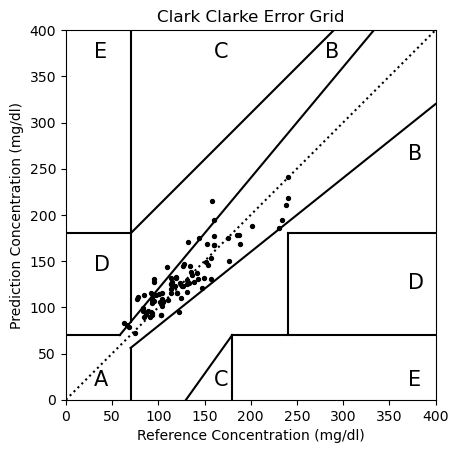

<Figure size 640x480 with 0 Axes>

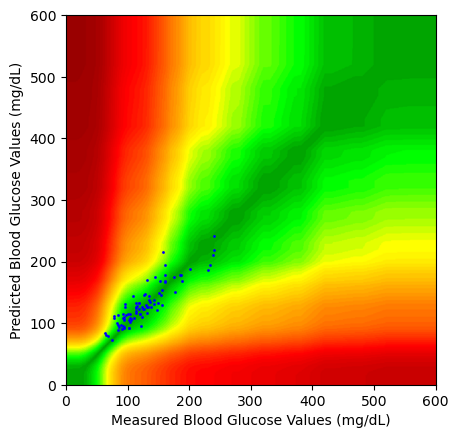

Pearson correlation coefficient: 0.8983382789680043
P-value: 1.8057253134998418e-32


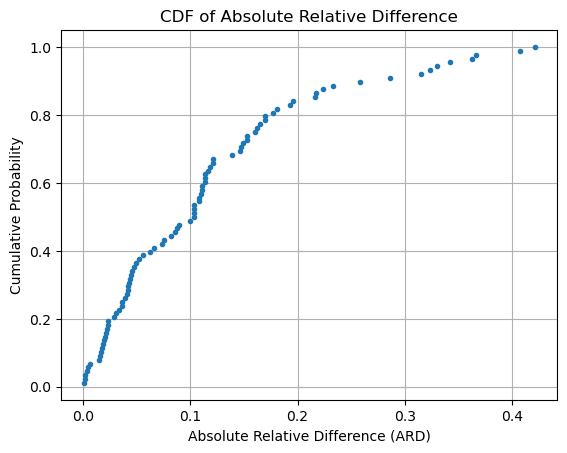

<Figure size 640x480 with 0 Axes>

In [24]:
xgb_reg = XGBRegressor(n_estimators=800
                    ,subsample=0.894736842105263
                    ,random_state=42
                    ,tree_method='hist'
                    ,device='cuda'
                    ,n_job=-1
                    ,learning_rate=0.26
                    ,gamma=0.006
                    ,max_depth=8)
xgb_reg.fit(X_train_selected, y_train_scaled)
y_pred_xgb = cp.asnumpy(xgb_reg.predict(X_test_selected))
mse_xgb = mean_squared_error(y_test_scaled, y_pred_xgb)
# print(f"ARD by signatures: {ARD(y_pred_xgb, y_test).mean()}" )
ard = ard_image(test_data_selected, xgb_reg, scaler_X=x_scaler, scaler_y=y_scaler)
print("ARD by images: ", ard)
print("Average ARD: ", ard.mean())
evaluate_image_CEG(test_data_selected, model=xgb_reg, scaler_X=x_scaler, scaler_y=y_scaler)
evaluate_image_SEG(test_data_selected, model=xgb_reg, scaler_X=x_scaler, scaler_y=y_scaler)
evaluate_image_PCC(test_data_selected, model=xgb_reg, scaler_X=x_scaler, scaler_y=y_scaler)
CDF(ard)

In [ ]:
# print all the index of ard that are greater 0.3
print(np.where(ard > 0.7))

In [ ]:
# Support Vector Regressor
svr_reg = cuSVR()
svr_reg.fit(X_train, y_train)
y_pred_svr = cp.asnumpy(svr_reg.predict(X_test))
mse_svr = mean_squared_error(y_test, y_pred_svr)
print(f"ARD by signatures: {ARD(y_pred_svr, y_test).mean()}" )
ard = ard_image(test_data, svr_reg)
print("ARD by images: ", ard)
print("Average ARD: ", ard.mean())
evaluate_image_CEG(test_data, model=svr_reg)
evaluate_image_SEG(test_data, model=svr_reg)

In [ ]:
evaluate_risk_SEG(test_data, model=svr_reg, patient_id=2)

In [ ]:
# Support Vector Regressor
# 50 bands, XGBoost
svr_reg = cuSVR()
svr_reg.fit(X_train_selected, y_train_scaled)
y_pred_svr = cp.asnumpy(svr_reg.predict(X_test_selected))
mse_svr = mean_squared_error(y_test_scaled, y_pred_svr)
print(f"ARD by signatures: {ARD(y_pred_svr, y_test).mean()}" )
ard = ard_image(test_data_selected, svr_reg)
print("ARD by images: ", ard)
print("Average ARD: ", ard.mean())
evaluate_image_CEG(test_data_selected, model=svr_reg)

In [ ]:
save_model(svr_reg, './Models/SVR_default_50selected_f.model')

In [ ]:
# Print the Mean Squared Error for each model
print("Mean Squared Error for Linear Regression:", mse_lin)
print("Mean Squared Error for Lasso Regression:", mse_lasso)
print("Mean Squared Error for Ridge Regression:", mse_ridge)
print("Mean Squared Error for Elastic Net:", mse_elastic)
print("Mean Squared Error for MLP:", mse_mlp)
print("Mean Squared Error for SVR:", mse_svr)
print("Mean Squared Error for XGBoost:", mse_xgb)
print("Mean Squared Error for PLS:", mse_pls)

In [ ]:
# # Trained PLS based on S1 and S2
# model = load_model('Models/PLS_regressor1.model')
# evaluate_image_CEG(test_data, model=model)

In [ ]:
# PLSR default
plsr_test = PLSRegression()
plsr_test.fit(X_train, y_train)
y_pred_plsr_test = cp.asnumpy(plsr_test.predict(X_test))
mse_plsr_test = mean_squared_error(y_test, y_pred_plsr_test)
# print(f"ARD by signatures: {ARD(y_pred_plsr_test, y_test).mean()}" )
ard = ard_image(test_data, plsr_test, scaler_X=x_scaler, scaler_y=y_scaler)
print("ARD by images: ", ard)
print("Average ARD: ", ard.mean())
evaluate_image_CEG(test_data, model=plsr_test, scaler_X=x_scaler, scaler_y=y_scaler)
evaluate_image_SEG(test_data, model=plsr_test, scaler_X=x_scaler, scaler_y=y_scaler)

In [ ]:
# PLSR
# Best parameter: tol: 1e-06, scale: False, n_components: 20, max_iter: 500
plsr_test = PLSRegression(n_components=25, scale=False, tol=1e-06, max_iter=500)
plsr_test.fit(X_train, y_train)
y_pred_plsr_test = cp.asnumpy(plsr_test.predict(X_test))
mse_plsr_test = mean_squared_error(y_test, y_pred_plsr_test)
print(f"ARD by signatures: {ARD(y_pred_plsr_test, y_test).mean()}" )
evaluate_image_CEG(test_data, model=plsr_test)
ard = ard_image(test_data, plsr_test)
print("ARD by images: ", ard)
print("Average ARD: ", ard.mean())

In [ ]:
step3 = np.asarray([ 8, 12, 19, 21, 26, 32, 33, 43, 48, 50, 55, 58, 59, 65]) * 3
step1 = np.asarray([ 24,  52,  58,  68,  76, 99, 105, 106, 127, 129, 144, 145, 146, 162, 177, 179])

step1 = selected_features
#step2 = selected_features * 2
print("step3: ", step3) 
print("step1: ", step1) 

In [ ]:
for image in test_data:
    print(image['label'])

In [ ]:
data_root = '../datasets/dataset_glucose/Hyperspectral'
file_train = 'train_data.csv'
file_test = 'test_data.csv'

In [ ]:
model = XGBRegressor(tree_method='hist', device='cuda', n_job=-1, random_state=42)

In [ ]:
# Experiment with different step size, Step 1-10
# XGBoost
ARD_bands = []
MSE = []
for i in range(1, 11):
    print(f"Step {i}")
    step = i
    X_train, y_train, X_test, y_test, test_data = prepare_data(data_root, file_train, file_test, step, 'hyper')
    scaler = RobustScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    for image in test_data:
        image['sig'] = scaler.transform(image['sig'])
    print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}, X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')
    model.fit(X_train, y_train)
    y_pred = cp.asnumpy(model.predict(X_test))
    mse = mean_squared_error(y_test, y_pred)
    print(f"ARD by signatures: {ARD(y_pred, y_test).mean()}" )
    ard = ard_image(test_data, model=model)
    print("ARD by images: ", ard)
    print("Average ARD: ", ard.mean())
    ARD_bands.append(ard.mean())
    MSE.append(mse)
    evaluate_image_CEG(test_data, model=model)

# Plot the ARD and MSE
plt.plot(range(1, 11), ARD_bands, label='ARD')

In [ ]:
plt.figure()
plt.plot(range(1, 11), MSE, label='MSE')

In [ ]:
data_root = '../datasets/dataset_glucose/Hyperspectral'
file_train = 'train_data.csv'
file_test = 'test_data.csv'

In [5]:
model = mlp_reg = MLPRegressor((200, 100, 16), random_state=42)

Step 2
Loading hyper dataset
Loading hyper dataset
X_train shape: (1477970, 102), y_train shape: (1477970,), X_test shape: (371280, 102), y_test shape: (371280,)
ARD by images:  [7.32263923e-02 9.63844284e-02 7.60851353e-02 4.21599671e-03
 1.82863295e-01 1.27513865e-02 5.65464832e-02 1.70319766e-01
 4.99674350e-01 8.33401922e-03 8.77782181e-02 1.70681700e-02
 2.32572686e-02 3.27450311e-04 7.20116049e-02 4.29775938e-02
 1.07841007e-02 1.46467671e-01 1.35469332e-01 9.66887772e-02
 1.07353769e-01 4.56279656e-03 4.80818041e-02 3.28678250e-01
 1.01140954e-01 2.75087673e-02 2.73884088e-01 1.05781093e-01
 1.07698172e-01 3.13499235e-02 7.12602586e-02 3.61746579e-01
 5.49203195e-02 8.83443505e-02 1.19273558e-01 5.61652295e-02
 4.46125641e-02 3.54463369e-01 2.37664599e-02 7.52631435e-03
 1.25249550e-02 1.78634953e-02 3.70374098e-02 3.75286251e-01
 2.10142270e-01 3.61613999e-03 4.67782468e-01 8.28386396e-02
 6.96257921e-03 6.41371608e-02 3.23894853e-03 4.74283099e-02
 1.56219020e-01 4.56364304e-0

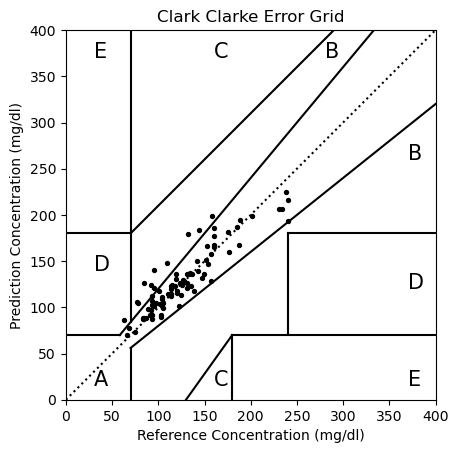

<Figure size 640x480 with 0 Axes>

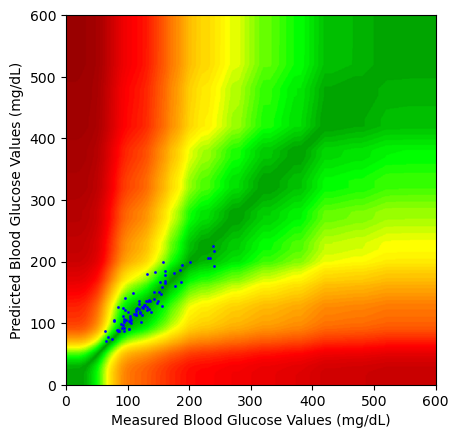

Pearson correlation coefficient: 0.9090885153977696
P-value: 1.8617389680188983e-34
Step 3
Loading hyper dataset
Loading hyper dataset
X_train shape: (1477970, 68), y_train shape: (1477970,), X_test shape: (371280, 68), y_test shape: (371280,)
ARD by images:  [8.47402364e-02 8.26522037e-02 9.13399607e-02 5.17806783e-03
 1.53536826e-01 5.55185694e-03 3.66889834e-02 1.90464452e-01
 4.90877748e-01 6.35851314e-03 1.03807449e-01 1.04607575e-01
 2.16683168e-02 1.73819866e-02 1.90552756e-01 4.66490611e-02
 2.38184221e-02 1.26723915e-01 1.41866744e-01 7.04614520e-02
 1.76438332e-01 1.56459007e-02 3.08416374e-02 5.06966233e-01
 1.09461814e-01 2.46285126e-02 2.34361619e-01 1.00380942e-01
 6.13996945e-02 2.63719726e-02 1.12389199e-01 3.50229502e-01
 4.06225249e-02 6.95216358e-02 2.12070972e-01 7.58228749e-02
 4.28939983e-03 2.58505911e-01 3.00412206e-03 1.49706565e-02
 3.11975777e-02 1.64523441e-02 3.62454243e-02 2.72950202e-01
 1.88572899e-01 8.55445862e-03 3.34850878e-01 1.14265338e-01
 1.41497

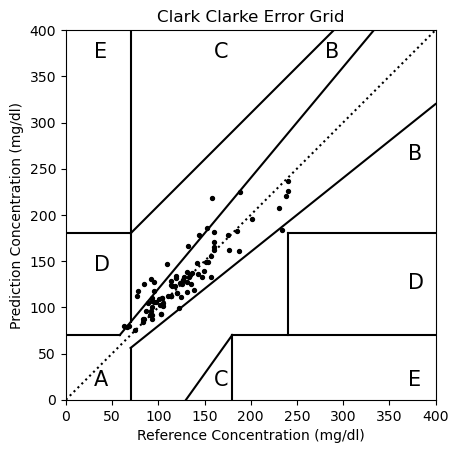

<Figure size 640x480 with 0 Axes>

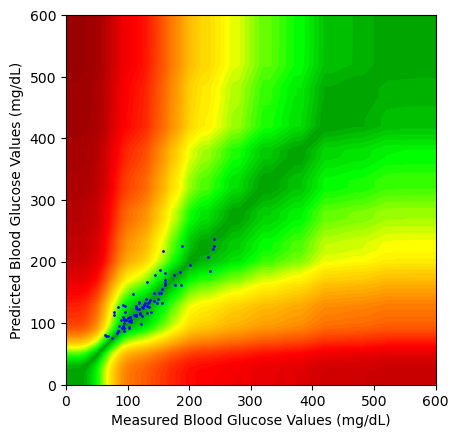

Pearson correlation coefficient: 0.9032228470228527
P-value: 2.414420629478166e-33


ValueError: x and y must have same first dimension, but have shapes (1,) and (2,)

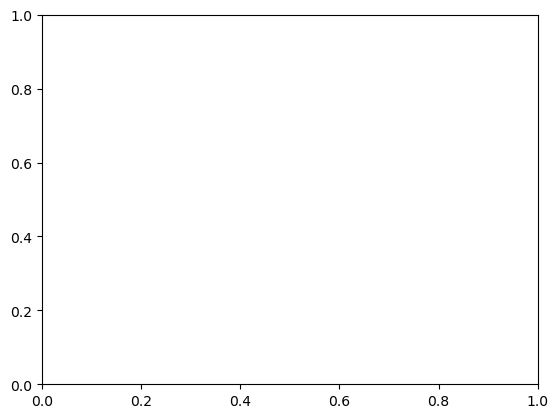

In [9]:
# Experiment with different step size, Step 1-3 22 Aug 2024
# MLP
ARD_bands = []
MSE = []
for i in range(2, 4):
    print(f"Step {i}")
    step = i
    X_train, y_train, X_test, y_test, test_data = prepare_data(data_root, file_train, file_test, step, 'hyper')
    X_scaler = RobustScaler()
    y_scaler = RobustScaler()
    X_train = X_scaler.fit_transform(X_train)
    X_test = X_scaler.transform(X_test)
    y_train = y_scaler.fit_transform(y_train.reshape(-1, 1)).ravel()
    y_test = y_scaler.transform(y_test.reshape(-1, 1)).ravel()
    print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}, X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')
    model.fit(X_train, y_train)
    y_pred = cp.asnumpy(model.predict(X_test))
    mse = mean_squared_error(y_test, y_pred)
    ard = ard_image(test_data, model=model, scaler_X=X_scaler, scaler_y=y_scaler)
    print("ARD by images: ", ard)
    print("Average ARD: ", ard.mean())
    ARD_bands.append(ard.mean())
    MSE.append(mse)
    evaluate_image_CEG(test_data, model=model, scaler_X=X_scaler, scaler_y=y_scaler)
    evaluate_image_SEG(test_data, model=model, scaler_X=X_scaler, scaler_y=y_scaler)
    evaluate_image_PCC(test_data, model=model, scaler_X=X_scaler, scaler_y=y_scaler)

# Plot the ARD and MSE
plt.plot(range(2, 4), ARD_bands, label='ARD')

In [8]:
ard = ard_image(test_data, model=model, scaler_X=X_scaler, scaler_y=y_scaler)
print("ARD by images: ", ard)
print("Average ARD: ", ard.mean())

ARD by images:  [0.05404883 0.07232015 0.06488845 0.01339066 0.14988075 0.01248427
 0.01232976 0.20343576 0.5187231  0.0467266  0.07474703 0.00603578
 0.03488515 0.00813625 0.12119783 0.05094481 0.01367546 0.11152108
 0.14232633 0.01738918 0.03786977 0.0012686  0.03318341 0.5026749
 0.07137602 0.00227071 0.2327852  0.11240634 0.03708242 0.0206705
 0.06997569 0.35820013 0.07688247 0.13264982 0.00802974 0.05246507
 0.04231282 0.27831906 0.13448153 0.0065623  0.01304315 0.07385555
 0.01296353 0.23580669 0.21087138 0.00084034 0.32787624 0.10192789
 0.01270363 0.03094544 0.01454042 0.02836272 0.17515382 0.04780893
 0.08940738 0.03332907 0.00168014 0.01515766 0.04118364 0.12452745
 0.04896802 0.04426627 0.07617118 0.14874506 0.01201844 0.02982693
 0.052338   0.03425319 0.00511369 0.29992533 0.01006573 0.34545913
 0.01343713 0.0540366  0.11550663 0.04849519 0.18519029 0.05168918
 0.03159479 0.16490301 0.06379133 0.05842967 0.12391977 0.38027924
 0.07717651 0.05205458 0.47011918 0.14479892]
Av

In [ ]:
plt.figure()
plt.plot(range(1, 11), MSE, label='MSE')

In [ ]:
data_root = '../datasets/dataset_glucose/Hyperspectral'
file_train = 'train_data.csv'
file_test = 'test_data.csv'

In [ ]:
model = cuKNeighborsRegressor()

In [ ]:
# Experiment with different step size, Step 1-10
# KNN
ARD_bands = []
MSE = []
for i in range(1, 11):
    print(f"Step {i}")
    step = i
    X_train, y_train, X_test, y_test, test_data = prepare_data(data_root, file_train, file_test, step, 'hyper')
    scaler = RobustScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    for image in test_data:
        image['sig'] = scaler.transform(image['sig'])
    print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}, X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')
    model.fit(X_train, y_train)
    y_pred = cp.asnumpy(model.predict(X_test))
    mse = mean_squared_error(y_test, y_pred)
    print(f"ARD by signatures: {ARD(y_pred, y_test).mean()}" )
    ard = ard_image(test_data, model=model)
    print("ARD by images: ", ard)
    print("Average ARD: ", ard.mean())
    ARD_bands.append(ard.mean())
    MSE.append(mse)
    evaluate_image_CEG(test_data, model=model)

# Plot the ARD and MSE
plt.plot(range(1, 11), ARD_bands, label='ARD')

In [ ]:
plt.figure()
plt.plot(range(1, 11), MSE, label='MSE')

In [ ]:
data_root = '../datasets/dataset_glucose/Hyperspectral'
file_train = 'train_data.csv'
file_test = 'test_data.csv'

In [ ]:
model = cuSVR()

In [ ]:
# Experiment with different step size, Step 1-10
# SVR
ARD_bands = []
MSE = []
for i in range(1, 11):
    print(f"Step {i}")
    step = i
    X_train, y_train, X_test, y_test, test_data = prepare_data(data_root, file_train, file_test, step, 'hyper')
    scaler = RobustScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    for image in test_data:
        image['sig'] = scaler.transform(image['sig'])
    print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}, X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')
    model.fit(X_train, y_train)
    y_pred = cp.asnumpy(model.predict(X_test))
    mse = mean_squared_error(y_test, y_pred)
    print(f"ARD by signatures: {ARD(y_pred, y_test).mean()}" )
    ard = ard_image(test_data, model=model)
    print("ARD by images: ", ard)
    print("Average ARD: ", ard.mean())
    ARD_bands.append(ard.mean())
    MSE.append(mse)
    evaluate_image_CEG(test_data, model=model)

# Plot the ARD and MSE
plt.plot(range(1, 11), ARD_bands, label='ARD')

In [ ]:
plt.figure()
plt.plot(range(1, 11), MSE, label='MSE')

In [ ]:
data_root = '../datasets/dataset_glucose/Hyperspectral'
file_train = 'train_data.csv'
file_test = 'test_data.csv'

In [ ]:
model = cuRF(random_state=42)

In [ ]:
# Experiment with different step size, Step 1-10
# Random Forest
ARD_bands = []
MSE = []
for i in range(1, 11):
    print(f"Step {i}")
    step = i
    X_train, y_train, X_test, y_test, test_data = prepare_data(data_root, file_train, file_test, step, 'hyper')
    scaler = RobustScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    for image in test_data:
        image['sig'] = scaler.transform(image['sig'])
    print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}, X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')
    model.fit(X_train, y_train)
    y_pred = cp.asnumpy(model.predict(X_test))
    mse = mean_squared_error(y_test, y_pred)
    print(f"ARD by signatures: {ARD(y_pred, y_test).mean()}" )
    ard = ard_image(test_data, model=model)
    print("ARD by images: ", ard)
    print("Average ARD: ", ard.mean())
    ARD_bands.append(ard.mean())
    MSE.append(mse)
    evaluate_image_CEG(test_data, model=model)

# Plot the ARD and MSE
plt.plot(range(1, 11), ARD_bands, label='ARD')